In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
input_size = 224

In [3]:
feats = np.load('forward_feats_3.npy')

In [4]:
ims = os.listdir('famine_data/ims_malawi_2016/')

In [5]:
len(ims)

28113

In [6]:
df_im_raw = pd.DataFrame.from_dict({'images': ims}); df_im_raw.head()

,images
0,-14.416666000000001_34.466666.png
1,-15.741666_34.491665999999995.png
2,-14.075_35.174999.png
3,-13.791666000000001_33.733332.png
4,-13.541666000000001_32.816666.png


In [7]:
im_to_const = pd.read_csv('famine_data/all_ims_guide.csv')

In [8]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images,clust_num
0,-17.050000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.05_35.174999_0.png,0
1,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.125_35.174999_0.png,0
2,-17.050000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.05_35.183332_0.png,0
3,-17.058333,35.183332,-17.09515,35.217213,0.0,2.039307,-17.058332999999998_35.183332_0.png,0
4,-17.100000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.1_35.183332_0.png,0


In [9]:
def parse_im(x):
    x = x.split('_')
    return x[0] + '_' + x[1] + '.png'

In [10]:
im_to_const['im_og'] = im_to_const['images'].apply(parse_im)

In [11]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images,clust_num,im_og
0,-17.050000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.05_35.174999_0.png,0,-17.05_35.174999.png
1,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.125_35.174999_0.png,0,-17.125_35.174999.png
2,-17.050000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.05_35.183332_0.png,0,-17.05_35.183332.png
3,-17.058333,35.183332,-17.09515,35.217213,0.0,2.039307,-17.058332999999998_35.183332_0.png,0,-17.058332999999998_35.183332.png
4,-17.100000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.1_35.183332_0.png,0,-17.1_35.183332.png


In [12]:
im_to_const.shape

(54404, 9)

In [13]:
df_im_raw['feat_index'] = np.arange(len(df_im_raw))

In [14]:
im_to_const = pd.merge(left=im_to_const, right=df_im_raw, left_on='im_og', right_on='images')

In [15]:
im_to_const.shape

(54404, 11)

In [16]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images_x,clust_num,im_og,images_y,feat_index
0,-17.050000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.05_35.174999_0.png,0,-17.05_35.174999.png,-17.05_35.174999.png,25523
1,-17.125000,35.174999,-17.09515,35.217213,0.0,2.039307,-17.125_35.174999_0.png,0,-17.125_35.174999.png,-17.125_35.174999.png,11065
2,-17.050000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.05_35.183332_0.png,0,-17.05_35.183332.png,-17.05_35.183332.png,4638
3,-17.058333,35.183332,-17.09515,35.217213,0.0,2.039307,-17.058332999999998_35.183332_0.png,0,-17.058332999999998_35.183332.png,-17.058332999999998_35.183332.png,21516
4,-17.100000,35.183332,-17.09515,35.217213,0.0,2.039307,-17.1_35.183332_0.png,0,-17.1_35.183332.png,-17.1_35.183332.png,25154


In [17]:
group = im_to_const.groupby(['clust_lat', 'clust_lon'])

In [18]:
num_clusts = len(group); num_clusts

780

In [19]:
x = np.zeros((num_clusts, 4096))
y = []

In [20]:
for i, g in enumerate(group):
    lat, long = g[0]
    im_sub = im_to_const[(im_to_const['clust_lat'] == lat) & (im_to_const['clust_lon'] == long)].reset_index(drop=True)
    agg_feats = np.zeros((len(im_sub), 4096))
    for j, d in im_sub.iterrows():
        agg_feats[j,:] = feats[d.feat_index]
    agg_feats = agg_feats.mean(axis=0)
    
    x[i,:] = agg_feats
    y.append(g[1]['consumption'].values[0])

In [21]:
y = np.array(y)
y_log = np.log(y)

In [22]:
x.shape

(780, 4096)

In [23]:
import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
import seaborn as sns

############################
######### Figure 3 #########
############################


def predict_consumption(
    X, y, dimension=None, k=5, k_inner=5, points=10,
        alpha_low=1, alpha_high=5, margin=0.25):
    """
    Plots predicted consumption
    """
    X = reduce_dimension(X, dimension)
    y_hat, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
    return X, y, y_hat, r2


def plot_predictions(country, y, y_hat, r2, margin):
    """
    Plots consumption predictions vs. true values.
    """
    slope, intercept, ymin, ymax, xmin, xmax = compute_plot_params(
        y, y_hat, margin)
    sns.set_style('white')
    plt.figure()
    plt.axis('equal')
    plt.scatter(y, y_hat, edgecolor='k', color='lightblue', s=20, marker='o')
    x_trend = np.array([xmin, xmax]) * 1.5
    y_trend = slope * x_trend + intercept
    plt.plot(x_trend, y_trend, 'b-', linewidth=2,
             color=sns.xkcd_rgb['french blue'])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('Log consumption expenditures', fontsize=14)
    plt.ylabel('Model predictions', fontsize=14)
    plt.title(country.capitalize() + ': $r^2 = {0:.2f}$'.format(r2))
    plt.show()


def compute_plot_params(y, y_hat, margin):
    """
    Computes parameters for plotting consumption predictions vs. true values.
    """
    slope, intercept, _, _, _ = stats.linregress(y, y_hat)
    ymin = min(y_hat) - margin
    ymax = max(y_hat) + margin
    xmin = min(y) - margin
    xmax = max(y) + margin
    return slope, intercept, ymin, ymax, xmin, xmax

############################
######## Figure 4ab ########
############################


def compare_models(
    country_path, survey, percentiles, dimension, k, k_inner, trials,
        poverty_line, multiples):
    """
    Evaluates and plots comparison of transfer learning and nightlight models.
    """
    r2s, r2s_nl = evaluate_percentiles(
        country_path, survey, percentiles, dimension, k, k_inner, trials)
    if survey == 'lsms':
        X, X_nl, y = load_and_reduce_country_by_percentile(
            country_path, survey, 1.0, dimension)
        fractions = compute_fractions(poverty_line, multiples, y)
        plot_percentiles_lsms(percentiles, multiples, r2s, r2s_nl, fractions)
    elif survey == 'dhs':
        plot_percentiles_dhs(percentiles, r2s, r2s_nl)


def load_and_reduce_country_by_percentile(
        country_path, survey, percentile, dimension):
    """
    Loads data for one country up to a certain percentile.
    """
    if survey == 'lsms':
        X, X_nl, y = load_country_lsms(country_path)
    elif survey == 'dhs':
        X, X_nl, y = load_country_dhs(country_path)
    X, X_nl, y = threshold_by_percentile(X, X_nl, y, percentile)
    X = reduce_dimension(X, dimension)
    return X, X_nl, y


def threshold_by_percentile(X, X_nl, y, percentile):
    """
    Threshold data by output percentile.
    """
    threshold = np.percentile(y, q=100*percentile)
    X = X[y <= threshold]
    X_nl = X_nl[y <= threshold]
    y = y[y <= threshold]
    return X, X_nl, y


def evaluate_percentiles(
        country_path, survey, percentiles, dimension, k, k_inner, trials):
    """
    Evaluate transfer learning and nightlight models for each percentile.
    """
    r2s = np.zeros((len(percentiles), trials))
    r2s_nl = np.zeros((len(percentiles), trials))
    for idx, percentile in enumerate(percentiles):
        for trial in xrange(trials):
            X, X_nl, y = load_and_reduce_country_by_percentile(
                country_path, survey, percentile, dimension)
            _, r2 = run_cv(
                X, y, k, k_inner, points=10, alpha_low=0, alpha_high=3,
                randomize=False)
            r2_nl = run_cv_ols(X_nl, y, k)
            r2s[idx, trial] = r2
            r2s_nl[idx, trial] = r2_nl
    r2s = r2s.mean(axis=1)
    r2s_nl = r2s_nl.mean(axis=1)
    return r2s, r2s_nl


def run_cv_ols(X, y, k):
    """
    Runs OLS in cross-validation to compute r-squared.
    """
    r2s = np.zeros((k,))
    kf = cross_validation.KFold(n=y.size, n_folds=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf:
        r2s, fold = evaluate_fold_ols(X, y, train_idx, test_idx, r2s, fold)
    return r2s.mean()


def evaluate_fold_ols(X, y, train_idx, test_idx, r2s, fold):
    """
    Evaluates one fold of outer CV using OLS.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ols(X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    if np.isnan(r2):
        r2 = 0
    r2s[fold] = r2
    return r2s, fold + 1


def train_and_predict_ols(X_train, y_train, X_test):
    """
    Trains OLS model and predicts test set.
    """
    ols = linear_model.LinearRegression()
    ols.fit(X_train, y_train)
    y_hat = ols.predict(X_test)
    return y_hat


def compute_fractions(poverty_line, multiples, y):
    """
    Computes the fraction of clusters below each multiple of the poverty line.
    """
    fractions = np.zeros((len(multiples),))
    for idx, multiple in enumerate(multiples):
        fractions[idx] = (
            np.exp(y) <= poverty_line * multiple).sum() / float(y.size)
    return fractions


def plot_percentiles_lsms(percentiles, multiples, r2s, r2s_nl, fractions):
    """
    Plots transfer learning model vs. nightlights model at each percentile.
    """
    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    lines = []
    percentiles = [100 * x for x in percentiles]
    for idx, multiple in enumerate(multiples):
        lines.append(
            plt.axvline(
                100 * fractions[idx], color='r', linestyle='dashed',
                linewidth=3.0 / (idx + 1),
                label=str(multiple) + 'x poverty line'))
    line_legend = plt.legend(
        handles=lines, title='Poverty line multiples:', loc='upper right',
        bbox_to_anchor=(0.5, 1), fontsize=10)
    plt.gca().add_artist(line_legend)
    curve1, = plt.plot(percentiles, r2s, label='Transfer learning')
    curve2, = plt.plot(percentiles, r2s_nl, label='Nightlights')
    plt.legend(
        handles=[curve1, curve2], loc='upper right',
        bbox_to_anchor=(0.5, 0.65))
    plt.xlabel('Poorest percent of clusters used', fontsize=14)
    plt.ylabel('$r^2$', fontsize=18)
    plt.show()


def plot_percentiles_dhs(percentiles, r2s, r2s_nl):
    """
    Plots transfer learning model vs. nightlights model at each
    """
    sns.set_style('white')
    plt.figure(figsize=(6, 6))
    percentiles = [100 * x for x in percentiles]
    plt.plot(percentiles, r2s)
    plt.plot(percentiles, r2s_nl)
    plt.legend(['Transfer learning', 'Nightlights'], loc='upper center')
    plt.xlabel('Poorest percent of clusters used', fontsize=14)
    plt.ylabel('$r^2$', fontsize=18)
    plt.show()

############################
######## Figure 4cd ########
############################


def run_randomization_test(
    country_names, country_paths, survey, dimension, k, k_inner, points,
        alpha_low, alpha_high, trials):
    """
    Runs randomization test for a set of countries.
    """
    data = load_data(country_paths, survey, dimension)
    true_r2s = compute_true_r2s(
        data, k, k_inner, points, alpha_low, alpha_high)
    shuffled_r2s = compute_shuffled_r2s(
        data, k, k_inner, points, alpha_low, alpha_high, trials)
    plot_shuffled_distributions(country_names, survey, shuffled_r2s, true_r2s)


def compute_true_r2s(data, k, k_inner, points, alpha_low, alpha_high):
    """
    Uses data to compute true model r2s.
    """
    true_r2s = []
    for (X, y) in data:
        _, r2 = run_cv(X, y, k, k_inner, points, alpha_low, alpha_high)
        true_r2s.append(r2)
    return true_r2s


def compute_shuffled_r2s(
        data, k, k_inner, points, alpha_low, alpha_high, trials):
    """
    Uses data to compute shuffled model r2s.
    """
    shuffled_r2s = np.zeros((len(data), trials))
    for data_idx, (X, y) in enumerate(data):
        for trial in range(trials):
            _, shuffled_r2s[data_idx, trial] = run_cv(
                X, y, k, k_inner, points, alpha_low, alpha_high,
                randomize=True)
    return shuffled_r2s


def plot_shuffled_distributions(country_names, survey, shuffled_r2s, true_r2s):
    """
    Plots shuffled r2 distributions vs. true model r2s.
    """
    colors = sns.color_palette('husl', len(country_names))
    sns.set_style('white')
    plt.figure(figsize=(8, 8))
    frame = plt.gca()
    for i in xrange(len(country_names)):
        plt.axvline(
            true_r2s[i], color=colors[i], linestyle='dashed', linewidth=2,
            label=country_names[i].capitalize() + ': $r^2={0:.2f}$'.format(
                true_r2s[i]))
    plt.legend(
        title='True {} Models:'.format(survey.upper()), loc='lower right',
        bbox_to_anchor=(0.6, 0.45), fontsize=12)
    for i in xrange(len(country_names)):
        sns.kdeplot(shuffled_r2s[i, :], shade=True, color=colors[i])
    plt.xlim((0, max(true_r2s) + 0.05))
    plt.xlabel('$r^2$', fontsize=18)
    plt.ylabel('Randomized $r^2$ distribution', fontsize=14)
    frame.yaxis.set_ticklabels([])
    plt.show()

############################
######### Figure 5 #########
############################


def evaluate_models(
    country_names, country_paths, survey, dimension, k, trials, points,
        alpha_low, alpha_high, cmap='Greens'):
    """
    Evaluates in- and out-of-country performance for models trained on set of
    countries given.
    """
    n = len(country_names)
    performance_matrix = np.zeros((trials, n, n))
    data = load_data(country_paths, survey, dimension=None)
    for trial in xrange(trials):
        for in_idx in xrange(n):
            performance_matrix[trial, :, in_idx] = compute_column(
                country_names[in_idx], data, in_idx, dimension, k, points,
                alpha_low, alpha_high)
    performance_matrix = performance_matrix.mean(axis=0)
    plot_model_performance(performance_matrix, country_names, cmap)
    return np.around(performance_matrix, decimals=2)


def compute_column(
    country_name, data, in_idx, dimension, k, points, alpha_low,
        alpha_high):
    """
    Evaluates in- and out-of-country performance for model trained on one
    country.
    """
    in_data = data[in_idx]
    out_data = list(data)
    out_data.pop(in_idx)
    if country_name == 'pooled':
        r2s_in, r2s_out = evaluate_pooled_r2s(
            out_data, dimension, k, points, alpha_low, alpha_high)
    else:
        r2s_in, r2s_out = evaluate_model_r2s(
            in_data, out_data, dimension, k, points, alpha_low, alpha_high)
    max_idx = np.argmax(r2s_in)
    r2s = list(r2s_out[:, max_idx])
    r2s.insert(in_idx, r2s_in[max_idx])
    r2s.reverse()
    r2s = np.array(r2s)
    return r2s


def evaluate_pooled_r2s(all_data, dimension, k, points, alpha_low, alpha_high):
    """
    Evaluates in- and out-of-country r2s for the pooled model.
    """
    X_all_full, y_all = [list(data) for data in zip(*all_data)]
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s_in = np.zeros((k, points))
    r2s_out = np.zeros((len(all_data), k, points))
    kf = []
    for i in xrange(len(X_all_full)):
        kf.append(list(cross_validation.KFold(
            n=all_data[i][1].size, n_folds=k, shuffle=True)))
    for fold in xrange(k):
        X_train, X_test, y_train, y_test = split_pooled_data(
            kf, fold, X_all_full, y_all)
        X_train, X_test, X_all = reduce_and_scale_features(
            X_train, X_test, X_all_full, dimension)
        r2s_in, r2s_out = evaluate_alphas(
            X_train, X_test, X_all, y_train, y_test, y_all, r2s_in, r2s_out,
            fold, alphas)
    return r2s_in.mean(axis=0), r2s_out.mean(axis=1)


def split_pooled_data(kf, fold, X_all_full, y_all):
    """
    Splits pooled training and test data for each fold.
    """
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for i in xrange(len(kf)):
        train_ind = kf[i][fold][0]
        test_ind = kf[i][fold][1]
        X_train.append(X_all_full[i][train_ind])
        X_test.append(X_all_full[i][test_ind])
        y_train.append(y_all[i][train_ind])
        y_test.append(y_all[i][test_ind])
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test


def evaluate_model_r2s(
        in_data, out_data, dimension, k, points, alpha_low, alpha_high):
    """
    Evaluates in- and out-of-country r2s.
    """
    X, y = in_data
    X_out_full, y_out = [list(data) for data in zip(*out_data)]
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s_in = np.zeros((k, points))
    r2s_out = np.zeros((len(out_data), k, points))
    kf = cross_validation.KFold(n=in_data[1].size, n_folds=k, shuffle=True)
    fold = 0
    for train_ind, test_ind in kf:
        X_train, X_test = X[train_ind], X[test_ind]
        y_train, y_test = y[train_ind], y[test_ind]
        X_train, X_test, X_out = reduce_and_scale_features(
            X_train, X_test, X_out_full, dimension)
        r2s_in, r2s_out = evaluate_alphas(
            X_train, X_test, X_out, y_train, y_test, y_out, r2s_in, r2s_out,
            fold, alphas)
        fold += 1
    return r2s_in.mean(axis=0), r2s_out.mean(axis=1)


def evaluate_alphas(
    X_train, X_test, X_out, y_train, y_test, y_out, r2s_in, r2s_out, fold,
        alphas):
    """
    Computes r2 for different regularization constants.
    """
    for idx, alpha in enumerate(alphas):
        ridge = linear_model.Ridge(alpha=alpha)
        ridge.fit(X_train.astype(np.float), y_train.astype(np.float))
        r2s_in[fold, idx] = compute_r2(ridge, X_test, y_test)
        for i in xrange(len(X_out)):
            r2s_out[i, fold, idx] = compute_r2(ridge, X_out[i], y_out[i])
    return r2s_in, r2s_out


def reduce_and_scale_features(X_train, X_test, X_out_full, dimension):
    """
    Reduces dimension and scales in- and out-of-country features.
    """
    pca = PCA(n_components=dimension)
    scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = scaler.fit_transform(pca.fit_transform(X_train))
    X_test = scaler.transform(pca.transform(X_test))
    X_out = []
    for X in X_out_full:
        X_out.append(scaler.transform(pca.transform(X)))
    return X_train, X_test, X_out


def compute_r2(model, X, y):
    """
    Computes model r2.
    """
    y_hat = model.predict(X)
    r2 = stats.pearsonr(y, y_hat)[0] ** 2
    return r2


def plot_circles(data, ax, **kwargs):
    """
    Plots circles for r2 values.
    """
    M = np.array(data)
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T
    w = np.abs(M).ravel()
    h = np.abs(M).ravel()
    a = 0
    circles = EllipseCollection(
        widths=w, heights=h, angles=a, units='x', offsets=xy,
        transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(circles)
    ax.set_xticks(np.arange(M.shape[1]))
    ax.set_xticklabels(data.columns)
    ax.set_yticks(np.arange(M.shape[0]))
    ax.set_yticklabels(data.index, rotation=90)
    return circles


def plot_model_performance(data, country_names, cmap='Greens'):
    """
    Makes plot for in- and out-of-country model performance.
    """
    data = pd.DataFrame(np.flipud(data))
    data.columns = [country.capitalize() for country in country_names]
    data.index = [country.capitalize() for country in country_names]
    sns.set_style('white')
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    circles = plot_circles(data, ax=ax, cmap=cmap)
    cb = fig.colorbar(circles)
    cb.set_label('$r^2$', fontsize=16)
    ax.margins(0.1)
    plt.xlabel('Country trained on', fontsize=16)
    plt.ylabel('Country evaluated on', fontsize=16)
    plt.show()

############################
######### General ##########
############################


def load_data(country_paths, survey, dimension):
    """
    Loads data for all surveys.
    """
    data = []
    for country_path in country_paths:
        X, y = load_and_reduce_country(country_path, survey, dimension)
        data.append((X, y))
    return data


def load_country_lsms(country_path):
    """
    Loads data for one LSMS country.
    """
    X = np.load(country_path + 'cluster_conv_features.npy')
    X_nl = np.load(country_path + 'cluster_nightlights.npy').reshape(-1, 1)
    y = np.load(country_path + 'cluster_consumptions.npy')
    hhs = np.load(country_path + 'cluster_households.npy')
    images = np.load(country_path + 'cluster_image_counts.npy')
    # Filter out single households and <10 images
    mask = np.logical_and((hhs >= 2), (images >= 10))
    X = X[mask]
    X_nl = X_nl[mask]
    y = y[mask]
    # Filter out 0 consumption clusters
    X = X[y > 0]
    X_nl = X_nl[y > 0]
    y = y[y > 0]
    y = np.log(y)
    return X, X_nl, y


def load_country_dhs(country_path):
    """
    Loads data for one DHS country.
    """
    X = np.load(country_path + 'cluster_conv_features.npy')
    X_nl = np.load(country_path + 'cluster_nightlights.npy').reshape(-1, 1)
    y = np.load(country_path + 'cluster_assets.npy')
    hhs = np.load(country_path + 'cluster_households.npy')
    images = np.load(country_path + 'cluster_image_counts.npy')
    # Filter out single households and <10 images
    mask = np.logical_and((hhs >= 2), (images >= 10))
    X = X[mask]
    X_nl = X_nl[mask]
    y = y[mask]
    return X, X_nl, y


def reduce_dimension(X, dimension):
    """
    Uses PCA to reduce dimensionality of features.
    """
    if dimension is not None:
        pca = PCA(n_components=dimension)
        X = pca.fit_transform(X)
    return X


def load_and_reduce_country(country_path, survey, dimension):
    """
    Loads data for one country and reduces the dimensionality of features.
    """
    if survey == 'lsms':
        X, _, y = load_country_lsms(country_path)
    elif survey == 'dhs':
        X, _, y = load_country_dhs(country_path)
    X = reduce_dimension(X, dimension)
    return X, y


def run_cv(X, y, k, k_inner, points, alpha_low, alpha_high, randomize=False):
    """
    Runs nested cross-validation to make predictions and compute r-squared.
    """
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = np.zeros((k,))
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        r2s, y_hat, fold = evaluate_fold(
            X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
            randomize)
    return y_hat, r2s.mean()


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat


def predict_inner_test_fold(X, y, y_hat, train_idx, test_idx, alpha):
    """
    Predicts inner test fold.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = scale_features(X_train, X_test)
    y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
    return y_hat


def find_best_alpha(X, y, k_inner, alphas):
    """
    Finds the best alpha in an inner CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            y_hat = predict_inner_test_fold(
                X, y, y_hat, train_idx, test_idx, alpha)
        r2 = stats.pearsonr(y, y_hat)[0] ** 2
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    return best_alpha


def evaluate_fold(
    X, y, train_idx, test_idx, k_inner, alphas, r2s, y_hat, fold,
        randomize):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    if randomize:
        random.shuffle(y_train)
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = stats.pearsonr(y_test, y_test_hat)[0] ** 2
    r2s[fold] = r2
    y_hat[test_idx] = y_test_hat
    return r2s, y_hat, fold + 1


In [28]:
ss = StandardScaler()
x_hat = ss.fit_transform(x)

In [36]:
n_train = int(0.7*(len(x_hat)))
inds = np.arange(len(x_hat))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

train_x = x_hat[train_ind]
valid_x = x_hat[valid_ind]

train_y = y_log[train_ind]
valid_y = y_log[valid_ind]

In [37]:
train_y.mean(), valid_y.mean()

(1.1442538386669037, 1.1470403388410042)

In [38]:
ridge = linear_model.Ridge()
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.6157279485187427

In [39]:
ridge.score(valid_x, valid_y)

-1.5823554500664605

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train_x, train_y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
_, _, _, r2 = predict_consumption(x_hat, y_log)

In [56]:
r2

0.14444184738097735

In [82]:
t = im_to_const# [(im_to_const['consumption']>5) & (im_to_const['consumption']<10)]

In [83]:
t = t.groupby('clust_num')

In [84]:
t = t.mean()

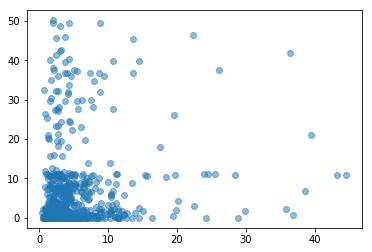

In [85]:
plt.scatter(t['consumption'], t['nightlight'], alpha=0.5)

In [50]:
(y_usable == 0).sum()

0

In [39]:
_, _, _, r2 = predict_consumption(x, np.array(y))

In [40]:
r2

0.07765331072804471

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [46]:
n_train = int(0.7*(len(x)))
inds = np.arange(len(x))
train_ind = np.random.choice(inds, n_train, replace=False)
valid_ind = np.delete(inds, train_ind)

In [47]:
y_usable = np.copy(y)

In [48]:
train_x = x[train_ind]
valid_x = x[valid_ind]

train_y = y_usable[train_ind]
valid_y = y_usable[valid_ind]

In [49]:
train_y.mean(), valid_y.mean()

(1.1139217866945952, 1.1151686066256046)

In [51]:
ridge = Ridge()
ridge.fit(train_x, train_y)
ridge.score(train_x, train_y)

0.27329042822451266

In [52]:
ridge.score(valid_x, valid_y)

0.038591186494688734

In [53]:
lr = LinearRegression()
lr.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
lr.score(train_x,train_y)

0.49174993416173446

In [55]:
lr.score(valid_x,valid_y)

-351136235938420.75

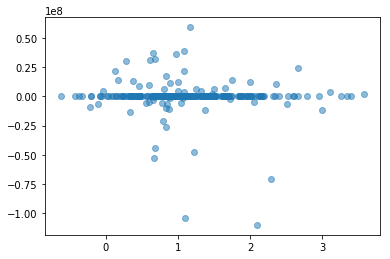

In [56]:
plt.scatter(valid_y, lr.predict(valid_x), alpha=0.5)

In [59]:
im_to_const.head()

,im_lat,im_lon,clust_lat,clust_lon,nightlight,consumption,images_x,clust_num,nightlight_bin,im_og,images_y,feat_index
0,-16.941666,35.208332,-16.985500,35.249900,0.036855,1.951277,-16.941666_35.208332_0.png,0,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
1,-16.941666,35.208332,-16.952974,35.203069,0.502674,2.171500,-16.941666_35.208332_1.png,1,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
2,-16.941666,35.208332,-16.934744,35.248479,0.616477,12.299129,-16.941666_35.208332_3.png,3,1,-16.941666_35.208332.png,-16.941666_35.208332.png,6754
3,-16.950000,35.208332,-16.985500,35.249900,0.036855,1.951277,-16.95_35.208332_0.png,0,1,-16.95_35.208332.png,-16.95_35.208332.png,298
4,-16.950000,35.208332,-16.952974,35.203069,0.502674,2.171500,-16.95_35.208332_1.png,1,1,-16.95_35.208332.png,-16.95_35.208332.png,298


In [62]:
im_to_const['consumption'].values.max()

44.5597701227943

In [61]:
2.73**3.79

44.983830314654554

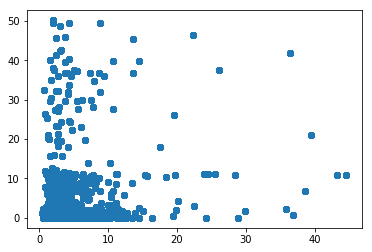

In [65]:
plt.scatter(im_to_const['consumption'], im_to_const['nightlight'], alpha=0.5)